# CNN for Hate Speech Classification

A very basic cnn model for hate speech classification.

Will be updated with the model from https://arxiv.org/abs/1408.5882

For all datasets we use: rectified linear units, filter windows (h) of 3, 4, 5 with 100 feature maps each, dropout rate (p) of 0.5, l2 constraint (s) of 3, and mini-batch size of 50.

In [1]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import gensim
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

from text_preprocess import clean_text
from results import plot_results

In [3]:
# Load datasets
train_df = pd.read_csv("C:\\Users\\aysen\\Documents\\GitHub\\hate_speech_models\\data\\annotations_metadata_train.csv")
test_df = pd.read_csv("C:\\Users\\aysen\\Documents\\GitHub\\hate_speech_models\\data\\annotations_metadata_test.csv")

# Text cleaning
X_train = train_df['text'].apply(clean_text)
X_test = test_df['text'].apply(clean_text)

# Tokenization and padding
tokenizer = Tokenizer()

tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
max_len = max(len(seq) for seq in X_train_sequences)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len)

"""tokenizer.fit_on_texts(X_test)
X_test_sequences = tokenizer.texts_to_sequences(X_train)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len)"""


# Binary label encoding
y_train = (train_df['label'] == 'hate').astype(int)
y_test = (test_df['label'] == 'hate').astype(int)

y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)


In [4]:
# Load Word2Vec model
word2vec_path = "C:\\Users\\aysen\\Documents\\GitHub\\hate_speech_models\\GoogleNews-vectors\\GoogleNews-vectors-negative300.bin"
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [5]:
# Create embedding matrix
embedding_dim = word2vec_model.vector_size
word_index = tokenizer.word_index
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]

In [6]:
# Hyperparameters
epochs = 10
batch_size = 32
learning_rate = 0.001
patience = 10
input_length = max_len

In [7]:
# CNN model
cnn_model = Sequential([

    # Embedding layer
    # Input shape: 2D tensor with shape: (batch_size, input_length)
    # Output shape: 3D tensor with shape: (batch_size, input_length, output_dim)
    Embedding(input_dim=num_words, output_dim=embedding_dim, weights=[embedding_matrix], input_length=input_length, trainable=True),
    
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
cnn_model_history = cnn_model.fit(X_train_padded, y_train_tensor, epochs=epochs, batch_size=batch_size, validation_split=0.2)



Epoch 1/10


48/48 [==============================] - 4s 50ms/step - loss: 0.6326 - accuracy: 0.6460 - val_loss: 0.5572 - val_accuracy: 0.7232
Epoch 2/10
48/48 [==============================] - 2s 44ms/step - loss: 0.3805 - accuracy: 0.8491 - val_loss: 0.4910 - val_accuracy: 0.7676
Epoch 3/10
48/48 [==============================] - 2s 44ms/step - loss: 0.1851 - accuracy: 0.9412 - val_loss: 0.4692 - val_accuracy: 0.8172
Epoch 4/10
48/48 [==============================] - 2s 44ms/step - loss: 0.0679 - accuracy: 0.9856 - val_loss: 0.5354 - val_accuracy: 0.7833
Epoch 5/10
48/48 [==============================] - 2s 45ms/step - loss: 0.0263 - accuracy: 0.9974 - val_loss: 0.5614 - val_accuracy: 0.7885
Epoch 6/10
48/48 [==============================] - 2s 45ms/step - loss: 0.0107 - accuracy: 1.0000 - val_loss: 0.6247 - val_accuracy: 0.7911
Epoch 7/10
48/48 [==============================] - 2s 45ms/step - loss: 0.0069 - accuracy: 0.9993 - val_loss: 0.6901 - val_accuracy: 0.7937
Epoch 8/1

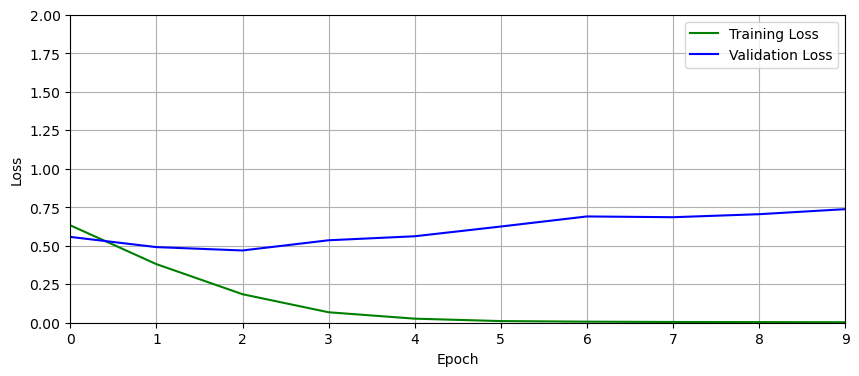

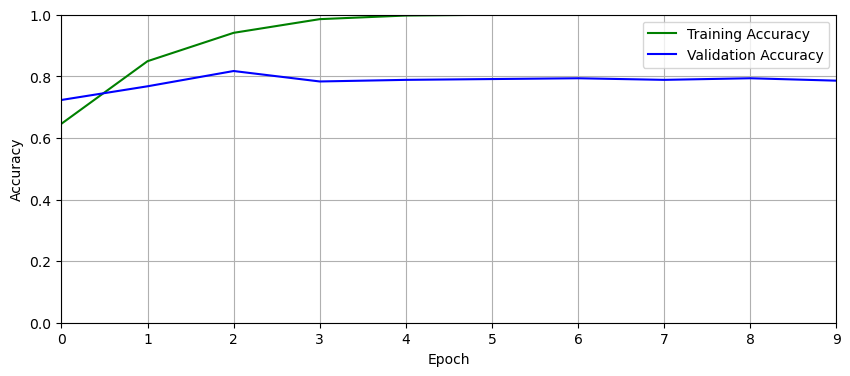

In [8]:
# Retrieve training results
train_loss = cnn_model_history.history["loss"]
train_acc  = cnn_model_history.history["accuracy"]
valid_loss = cnn_model_history.history["val_loss"]
valid_acc  = cnn_model_history.history["val_accuracy"]
   
plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            ylim = [0.0, 2.0],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"], epochs=epochs);
 
plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"], epochs=epochs)

In [9]:
# Tokenization and padding
tokenizer = Tokenizer()

tokenizer.fit_on_texts(X_test)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len)


test_loss, test_acc = cnn_model.evaluate(X_test_padded, y_test_tensor)
print(f"Test accuracy: {test_acc*100:.3f}")

y_pred = cnn_model.predict(X_test_padded)

# Convert predictions to binary values (0 or 1) based on a threshold
threshold = 0.5
y_pred_binary = [1 if pred > threshold else 0 for pred in y_pred]

# Evaluate the performance using metrics like accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

print('\n')
print(classification_report(y_test, y_pred_binary, target_names=['noHate', 'hate']))

15/15 [==============================] - 0s 10ms/step - loss: 2.2176 - accuracy: 0.5146
Test accuracy: 51.464
15/15 [==============================] - 0s 15ms/step
F1 Score: 0.5186721991701244
Precision: 0.51440329218107
Recall: 0.5230125523012552


              precision    recall  f1-score   support

      noHate       0.51      0.51      0.51       239
        hate       0.51      0.52      0.52       239

    accuracy                           0.51       478
   macro avg       0.51      0.51      0.51       478
weighted avg       0.51      0.51      0.51       478

